## 2095 mean and risk aversion damages figure


### Importing

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os, sys
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
USER = os.getenv('USER')
sys.path.append(f'/home/{USER}/repos/agriculture/1_code/5_crop_shift')
from agval.utils.ag_weights import snag_weights
sns.set_context('poster')

### Gathering data

In [2]:
# adding up and risk aversion fit for line plot

years = range(2093, 2098)

adding_up = xr.open_dataset("/mnt/CIL_integration/menu_results_histclim_bottom_coded/AMEL/2020/adding_up_constant_eta2_rho0_damage_function_fit.nc4").sel({'model':'IIASA GDP', 'ssp' : 'SSP3'}).to_dataframe().reset_index()
adding_up['y_hat'] = adding_up['y_hat']/10**12
adding_up['scenario'] = "adding up"

risk_aversion = xr.open_dataset("/mnt/CIL_integration/menu_results_histclim_bottom_coded/AMEL/2020/risk_aversion_constant_eta2_rho0_damage_function_fit.nc4").sel({'model':'IIASA GDP', 'ssp' : 'SSP3'}).to_dataframe().reset_index()
risk_aversion['y_hat'] = risk_aversion['y_hat']/10**12
risk_aversion['scenario'] = "risk aversion"

yhat = adding_up.append(risk_aversion)
yhat = yhat.reset_index().drop(columns=['index'])

In [3]:
# adding up and risk aversion points for scatter 

adding_up_pt = pd.read_csv("/mnt/CIL_integration/menu_results_histclim_bottom_coded/AMEL/2020/adding_up_constant_eta2_rho0_damage_function_points.csv")
adding_up_pt = adding_up_pt.loc[(adding_up_pt.model == 'IIASA GDP') & (adding_up_pt.ssp == 'SSP3')]
adding_up_pt['damages'] = adding_up_pt['damages']/10**12
adding_up_pt['scenario'] = "adding up"

risk_aversion_pt = pd.read_csv("/mnt/CIL_integration/menu_results_histclim_bottom_coded/AMEL/2020/risk_aversion_constant_eta2_rho0_damage_function_points.csv")
risk_aversion_pt = risk_aversion_pt.loc[(risk_aversion_pt.model == 'IIASA GDP') & (risk_aversion_pt.ssp == 'SSP3')]
risk_aversion_pt['damages'] = risk_aversion_pt['damages']/10**12
risk_aversion_pt['scenario'] = "risk aversion"

points = adding_up_pt.append(risk_aversion_pt)

In [4]:
# gmst anomaly data for kernel density plot

gmst = pd.read_csv('/mnt/Global_ACP/damage_function/GMST_anomaly/GMTanom_all_temp_2001_2010_smooth.csv')
gmst = gmst.rename(columns={'temp': 'anomaly'})
gmst = gmst.loc[gmst.year.isin(years)]

In [5]:
# getting weights for kernel density plot

weights = []
for rcp in ['rcp45', 'rcp85']:
    dt = snag_weights(rcp)
    dt['rcp'] = rcp
    weights.append(dt)
weights = pd.concat(weights)

# changing GCM values to match the uppercase GCM values in weight dataframe
gmst['gcm'] = gmst.gcm.str.upper()

In [6]:
# ar5 vs ar6 anomaly data

anom = pd.read_csv("/mnt/CIL_integration/explainer_plot_data/ar5_ar6_gmst_for_histograms.csv")
median_ar5=anom['ar5_anomaly'].median()
median_ar6=anom['ar6_anomaly'].median()

In [7]:
# text specs
text_specs = dict(
    fontsize=15,
    xycoords='axes fraction'
)

# palette = ["#0077a0", "#fd1115"]
palette1=sns.color_palette(["#0077a0", "#fd1115"])
palette2=sns.color_palette(["mediumslateblue", "mediumseagreen"])
palette = ['mediumslateblue', 'mediumseagreen']

/home/nsharma/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.6 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


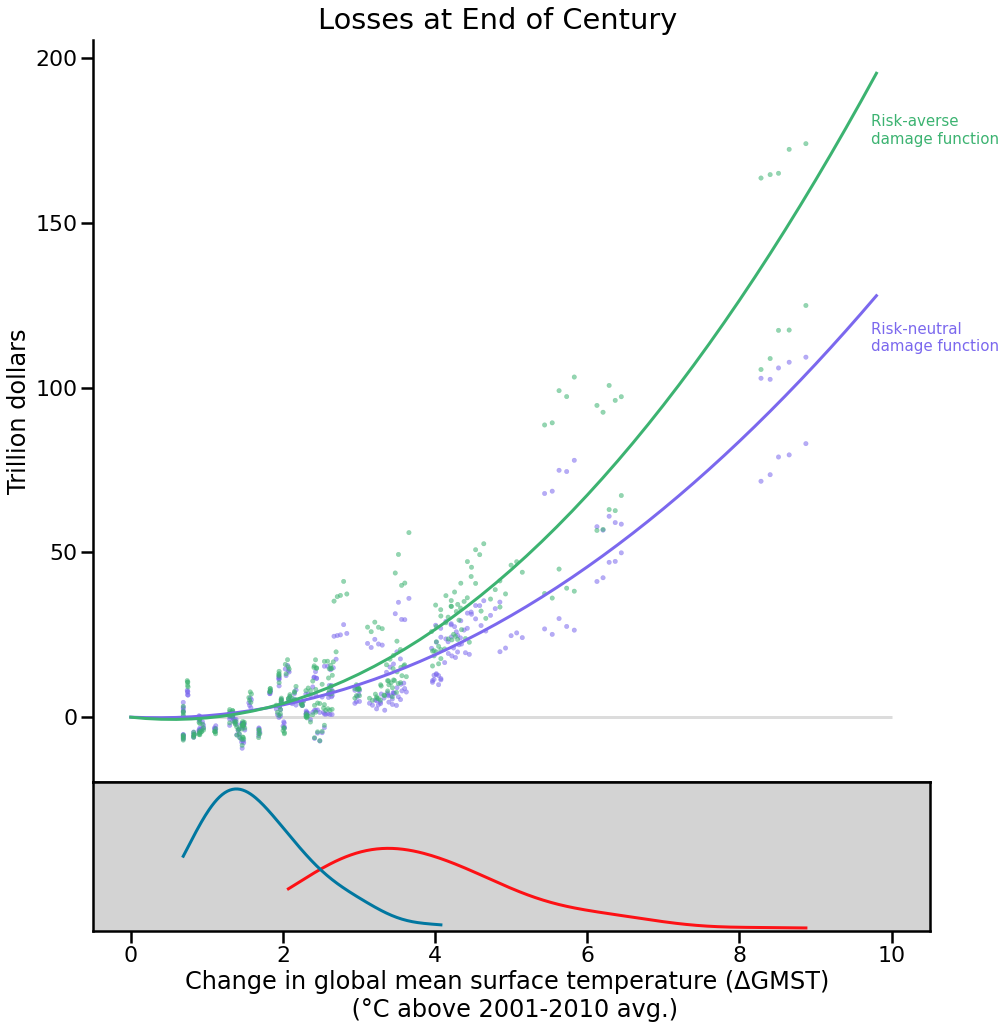

In [8]:
# general settings
fig, ax = plt.subplots(2,1, figsize=(15,15), 
                       sharex='col', sharey='row',
                       gridspec_kw={'height_ratios': [5, 1]}
                      )
plt.subplots_adjust(hspace=0, wspace=0.3, top=0.95)
fig.suptitle("Losses at End of Century")


# zero line
ax[0].hlines(0, yhat.anomaly.min(), 10, color='gainsboro',zorder=1)

# scatterplots
sns.scatterplot(data=points.loc[points.year.isin(years)],
                x='anomaly',
                y='damages', 
                hue='scenario',
                palette=palette2,
                edgecolor='face',
                alpha=0.55,
                s=20,
                legend=False,
                ax=ax[0]
               )

# central lineplot
sns.lineplot(data=yhat.loc[(yhat.year == 2095) & (yhat.anomaly < 10)],
            x = 'anomaly',
            y = 'y_hat',
            hue='scenario', 
            palette=palette2, 
            legend=False,
            ax=ax[0]
            )
ax[0].set_ylabel("Trillion dollars")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# annotate
plt.annotate('Risk-neutral \ndamage function', (0.93, 3.9),
             color=palette[0],
             **text_specs
            )
plt.annotate('Risk-averse \ndamage function', (0.93, 5.3),
             color=palette[1],
             **text_specs
            )

# density graph at the bottom
sns.kdeplot(data=gmst.merge(weights, on=['rcp', 'gcm']), x="anomaly", 
            bw=0.6,
            cut=0,
            hue='rcp', 
            palette=palette1, 
            legend=False,
            weights='weight',
            ax=ax[1])

ax[1].set_yticks([])
ax[1].set_facecolor('lightgrey')
ax[1].set_ylabel('')
ax[1].set_xlabel('Change in global mean surface temperature (ΔGMST) \n (°C above 2001-2010 avg.)')

# save plot
plt.savefig('/mnt/CIL_integration/explainer_plots/fig_2.pdf', bbox_inches='tight')

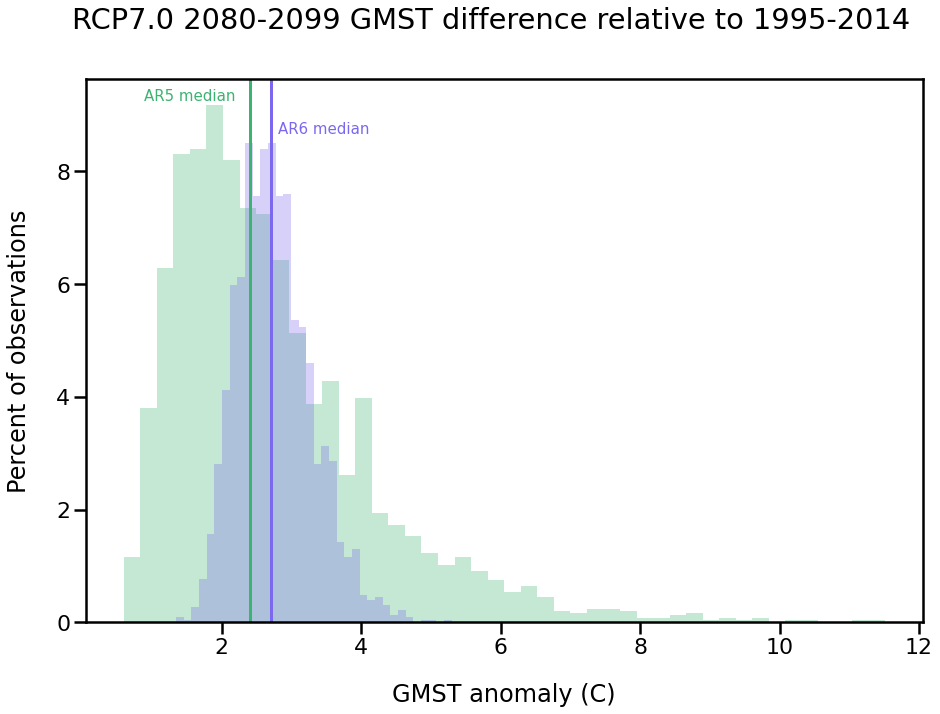

In [39]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
fig.suptitle("RCP7.0 2080-2099 GMST difference relative to 1995-2014")

# histograms
sns.histplot(anom,
             x='ar5_anomaly',
             stat='percent',
             color=palette[1],
             edgecolor=None,
             alpha=0.3,
             ax=ax
            )

sns.histplot(anom,
             x='ar6_anomaly',
             stat='percent',
             color=palette[0],
             edgecolor=None,
             alpha=0.3,
             ax=ax
            )

# annotate
plt.annotate('AR5 median', (0.07, 0.96),
             color=palette[1],
             **text_specs
            )

plt.annotate('AR6 median', (0.23, 0.9),
             color=palette[0],
             **text_specs
            )

# median vertical lines
plt.axvline(median_ar5, color=palette[1])
plt.axvline(median_ar6, color=palette[0])

plt.ylabel('Percent of observations', labelpad=25)
plt.xlabel('GMST anomaly (C)', labelpad=25)

# save plot
plt.savefig('/mnt/CIL_integration/explainer_plots/fig_ar5_ar6.pdf', bbox_inches='tight')